# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.


In [ ]:
from google.colab import files
files.download("/content/sample_data")

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

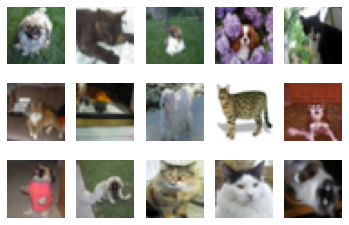

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [ ]:
num_train = len(train_loader)
print("There are {} training examples for the combined cat and dog classes".format(num_train))

num_valid = len(val_loader)
print("There are {} validation examples for the combined cat and dog classes".format(num_valid))

num_test = len(test_loader)
print("There are {} testing examples for the combined cat and dog classes".format(num_test))

There are 8000 training examples for the combined cat and dog classes
There are 2000 validation examples for the combined cat and dog classes
There are 2000 testing examples for the combined cat and dog classes


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [ ]:
# Training solely based on the training data will lead to the model memorizing
# the data and causing an overfit that will not be able to learn properly.
# Training our model using the validation data allows us to use seperate data
# from the training and testing data that will allow us to validate the accuracy
# of our model while also giving us feedback on adjusting hyperparameters.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
def get_product(list_of_stuff):
  sum = list_of_stuff[0] # add the first element on default so you're not multiplying by zero
  if len(list_of_stuff) == 1:
    return sum
  else:
    for i in range(1,len(list_of_stuff)):
      sum *= list_of_stuff[i]
  return sum

sum_small = 0
for param in small_net.parameters():
    sum_small += get_product(param.shape)
    print(param.shape)

print("\n", "------------------------", "\n")

sum_large = 0
for parame in large_net.parameters():
    sum_large += get_product(parame.shape)
    print(parame.shape)

print("The total number of parameters in small_net is:", sum_small)
print("The total number of parameters in large_net is:", sum_large)


torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])

 ------------------------ 

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
The total number of parameters in small_net is: 386
The total number of parameters in large_net is: 9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.001, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

In [ ]:
# The default value of batch_size is 64, the default learning rate is 0.01, and the default number of epochs is 30.

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
smallnet = SmallNet()
train_net(smallnet, num_epochs=5)
# The five main files written to disk are:
# model_small_bs64_Ir0.01_epoch0
# model_small_bs64_Ir0.01_epoch1
# model_small_bs64_Ir0.01_epoch2
# model_small_bs64_Ir0.01_epoch3
# model_small_bs64_Ir0.01_epoch4
# Each of these files contains the information on the model at each of the epoch checkpoints.
# For example, model_small_bs64_Ir0.01_epoch0 has information on the model
# after epoch0 has been trained for.
# In addition to those 5 files, there are also the 4 files:
# model_small_bs64_lr0.01_epoch4_train_err.csv
# model_small_bs64_lr0.01_epoch4_train_loss.csv
# model_small_bs64_lr0.01_epoch4_val_err.csv
# model_small_bs64_lr0.01_epoch4_val_loss.csv
# which hold the different loss and error values for the training and
# validation data sets.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.422375, Train loss: 0.6734880151748657 |Validation err: 0.368, Validation loss: 0.655155535787344
Epoch 2: Train err: 0.37375, Train loss: 0.6490988359451294 |Validation err: 0.3895, Validation loss: 0.6699541658163071
Epoch 3: Train err: 0.355125, Train loss: 0.6336915016174316 |Validation err: 0.3375, Validation loss: 0.6244697328656912
Epoch 4: Train err: 0.33375, Train loss: 0.612397714138031 |Validation err: 0.3335, Validation loss: 0.6157220471650362
Epoch 5: Train err: 0.318625, Train loss: 0.5975491554737091 |Validation err: 0.3195, Validation loss: 0.6067297793924809
Finished Training
Total time elapsed: 13.56 seconds


### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
Smallnet = SmallNet()
train_net(Smallnet)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.446375, Train loss: 0.6813716783523559 |Validation err: 0.3865, Validation loss: 0.6602997500449419
Epoch 2: Train err: 0.37325, Train loss: 0.6497629323005676 |Validation err: 0.3845, Validation loss: 0.6575995869934559
Epoch 3: Train err: 0.359875, Train loss: 0.6388978385925292 |Validation err: 0.3495, Validation loss: 0.6291275043040514
Epoch 4: Train err: 0.346375, Train loss: 0.6246587996482849 |Validation err: 0.356, Validation loss: 0.6221408396959305
Epoch 5: Train err: 0.334375, Train loss: 0.6153830280303955 |Validation err: 0.3275, Validation loss: 0.6188967823982239
Epoch 6: Train err: 0.318, Train loss: 0.6036732516288758 |Validation err: 0.339, Validation loss: 0.6094125052914023
Epoch 7: Train err: 0.315625, Train loss: 0.5944745948314667 |Validation err: 0.329, Validation loss: 0.5974238961935043
Epoch 8: Train err: 0.3085, Train loss: 0.5829453563690186 |Validation err: 0

In [ ]:
Largenet = LargeNet()
train_net(Largenet)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.44475, Train loss: 0.6900203123092651 |Validation err: 0.4285, Validation loss: 0.6807542946189642
Epoch 2: Train err: 0.4195, Train loss: 0.67819615650177 |Validation err: 0.413, Validation loss: 0.6741204150021076
Epoch 3: Train err: 0.39875, Train loss: 0.6658886175155639 |Validation err: 0.3925, Validation loss: 0.6518177818506956
Epoch 4: Train err: 0.373875, Train loss: 0.6490470728874207 |Validation err: 0.406, Validation loss: 0.6635930277407169
Epoch 5: Train err: 0.35375, Train loss: 0.6330237889289856 |Validation err: 0.353, Validation loss: 0.6284337677061558
Epoch 6: Train err: 0.339125, Train loss: 0.6160062110424042 |Validation err: 0.34, Validation loss: 0.6150468923151493
Epoch 7: Train err: 0.32625, Train loss: 0.6001663441658021 |Validation err: 0.335, Validation loss: 0.6086486000567675
Epoch 8: Train err: 0.313875, Train loss: 0.5828366029262543 |Validation err: 0.3325

In [ ]:
# According to the output of the code, small_net took around 129.58 seconds to train and large_net
# took around 145.13 seconds to train. This means that small_net took less time to train, which is expected,
# as it has fewer parameters than large_net, which we previously calculated,
# meaning it should take less time to train.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

Display of trajectory of training/validation error and loss for SmallNet


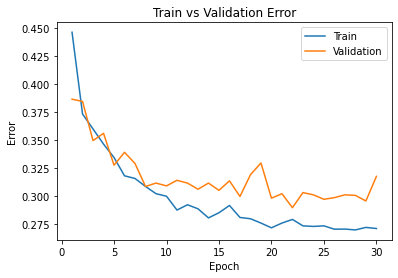

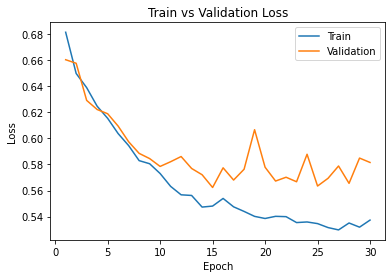

Display of trajectory of training/validation error and loss for LargeNet


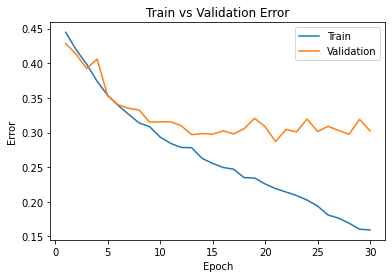

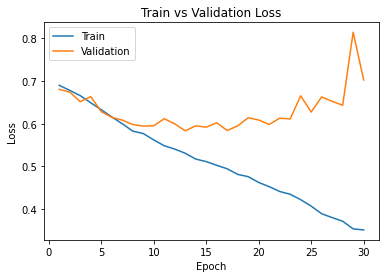

In [ ]:
#model_path = get_model_name("small", batch_size=??, learning_rate=??, epoch=29)
small_model_path = get_model_name("small", batch_size = 64, learning_rate = 0.01, epoch=29)
#large_model_path = get_model_name("large", epoch=29)

print("Display of trajectory of training/validation error and loss for SmallNet")
plot_training_curve(small_model_path)

large_model_path = get_model_name("large", batch_size = 64, learning_rate = 0.01, epoch = 29)

print("Display of trajectory of training/validation error and loss for LargeNet")
plot_training_curve(large_model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [ ]:
# For small_net, there is evidence of underfitting at the beginning for both training
# and validation. As the epoch's increase, the error and loss of both the training
# and validation steadily decrease, which is good.
# For large net, we also see underfitting near the early epoch's, evident in the high
# error values for both the training and validation. However, as the epoch's increase while
# the training error and loss values steadily decrease, the error value reaches a plateau
# and the loss increases, which is a direct sign of overfitting.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360013961792 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589712142945 |Validation err: 0.4305, Validation loss: 0.691649341955781
Epoch 3: Train err: 0.43575, Train loss: 0.6916067280769348 |Validation err: 0.4285, Validation loss: 0.690854424610734
Epoch 4: Train err: 0.43, Train loss: 0.690861343383789 |Validation err: 0.424, Validation loss: 0.6896595880389214
Epoch 5: Train err: 0.434125, Train loss: 0.6899195008277893 |Validation err: 0.4195, Validation loss: 0.6886935643851757
Epoch 6: Train err: 0.43575, Train loss: 0.6887411961555481 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774147033691 |Validation err: 0.4185, Validation loss: 0.6851982977241278
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.412,

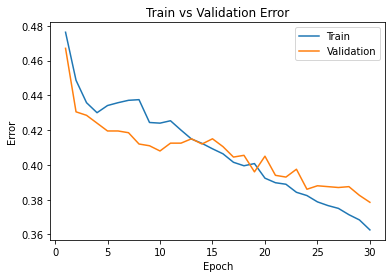

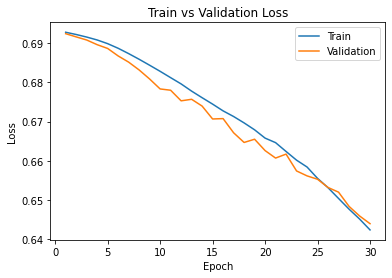

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, 64, 0.001, 30)
training_curve_large = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(training_curve_large)

In [ ]:
# as evident from the results above, we can see that the new large_net model took
# longer to train, with the original model taking around 145 seconds to train and this
# model taking 165 seconds to train. As we can see, one effect of lowering the learning
# rate is that it significantly increases the time taken to train the model.
# Upon further inspection of the graphs produced, we can see that gave an overall
# higher error and loss value for both training and validation. We can see that the
# decrease in the error and loss values is a lot slower than with a higher learning rate.
# However, lowering the learning rate did get rid of the overfitting that previously
# occured in the validation loss and error values. We can see that rather than
# the error hitting a plateau and the loss increasing, both steadily decrease
# as the number of epochs increases.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

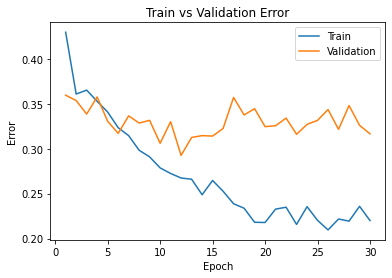

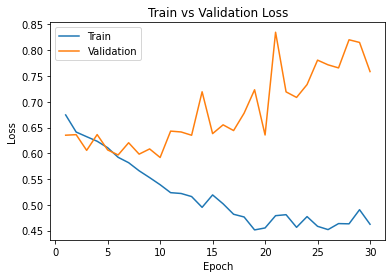

In [ ]:
large_net = LargeNet()
train_net(large_net, 64, 0.1, 30)
training_curve_large2 = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(training_curve_large2)

In [ ]:
# This model took the shortest out of all three models to train. The difference in time
# with the model where the learning rate was 0.001 was quite noticeable while the
# difference in time with the original model was quite small. Increasing the learning
# rate increases the error and loss values in both the training and validation.
# Furthermore, while the training error and loss decrease as the epochs increase,
# the validation error and loss begin to increase a lot earlier than before. This
# is a definitive sign of severe overfitting.

# What can be concluded from the experiments adjusting learning rate is that a higher
# learning rate does lead to shorter times, but it also leads to increased overfitting of the model,
# while a lower learning rate slows down the training process but results in
# steadily decreasing loss and error values for both the training and validation.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

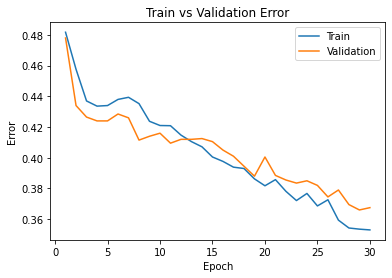

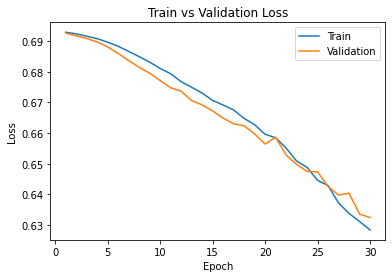

In [ ]:
large_net = LargeNet()
train_net(large_net, 512, 0.01, 30)
training_curve_large3 = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(training_curve_large3)

In [ ]:
# Increasing the batch size decreased the time needed to train. Furthermore,
# we can see that increasing the batch size increased the overall loss and error values
# in the training data. It also kept the loss and error values for validation relatively
# the same as before, but it got rid of the overfitting that previously occured.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

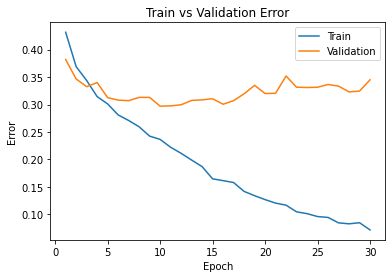

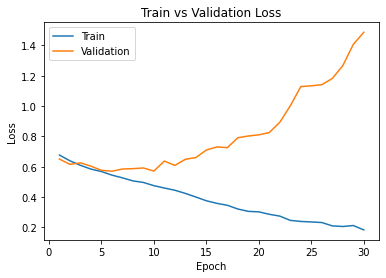

In [ ]:
large_net = LargeNet()
train_net(large_net, 16, 0.01, 30)
training_curve_large4 = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(training_curve_large4)

In [ ]:
# By increasing the batch size, the time taken to train increased, as expected.
# By decreasing the batch size, we can see that the overall loss and error values
# for the training data are lowered, but this comes at the cost of overfitting and
# very large error and loss values for the validation data.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [ ]:
# Based on the plots from above I have chosen to train using the hyperparameters
# (network = largenet, batch_size = 512, learning_rate = 0.001). From the previous
# examples, we see that using the largenet network results in smaller validation
# and training errors, but it does result in overfitting when used with larger epoch
# values. To minimize the amount of overfitting that occurs at greater values,
# the batch_size and learning_rate were chosen accordingly. For the batch_size, we
# found that using larger batch_sizes helped decrease the overfitting that occured
# when using a lower batch size of 16. Furthermore, the learning rate was set to 0.001
# because it was observed that lowering the learning rate, while increasing the time
# to train, did help get rid of the overfitting and did result in a decrease in both
# the training and validation errors and loss values as the epochs increased.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.503375, Train loss: 0.6931838057935238 |Validation err: 0.5065, Validation loss: 0.6938159316778183
Epoch 2: Train err: 0.503625, Train loss: 0.6930505335330963 |Validation err: 0.5085, Validation loss: 0.6936859637498856
Epoch 3: Train err: 0.50375, Train loss: 0.6929039172828197 |Validation err: 0.51, Validation loss: 0.6936599463224411
Epoch 4: Train err: 0.503375, Train loss: 0.6928931772708893 |Validation err: 0.5055, Validation loss: 0.69358791410923
Epoch 5: Train err: 0.502875, Train loss: 0.6926453597843647 |Validation err: 0.5065, Validation loss: 0.6934588700532913
Epoch 6: Train err: 0.501125, Train loss: 0.6925876066088676 |Validation err: 0.5045, Validation loss: 0.6932799071073532
Epoch 7: Train err: 0.498375, Train loss: 0.6924448721110821 |Validation err: 0.4995, Validation loss: 0.6931879669427872
Epoch 8: Train err: 0.499, Train loss: 0.6922980695962906 |Validation err: 

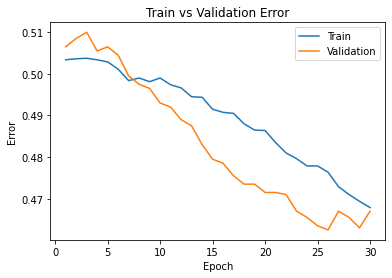

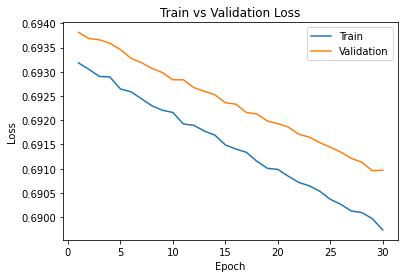

In [ ]:
large_net = LargeNet()
train_net(large_net, 512, 0.001, 30)
training_curve_large_new = get_model_name("large", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(training_curve_large_new)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

In [ ]:
# The results from the previous set of hyperparameters was good, but were not ideal.
# We could see that the rate at which the training and validation loss and error values
# decreased was quite slow, and the function did show some overfitting, as seen in the
# sudden increase in validation error in between 25-30 epochs. In order to combat these
# issues, the batch size and network were kept the same, but the learning rate and
# number of epochs was changed. To combat the overfitting caused by the larger epoch values,
# this was reduced to 17, and to combat the slow decrease in the loss and error,
# the learning rate was increased to 0.02.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.50175, Train loss: 0.6933403611183167 |Validation err: 0.4885, Validation loss: 0.6918623596429825
Epoch 2: Train err: 0.458, Train loss: 0.6916962489485741 |Validation err: 0.425, Validation loss: 0.6909449696540833
Epoch 3: Train err: 0.442625, Train loss: 0.690452829003334 |Validation err: 0.433, Validation loss: 0.6893054991960526
Epoch 4: Train err: 0.436, Train loss: 0.6885306425392628 |Validation err: 0.4145, Validation loss: 0.6863629519939423
Epoch 5: Train err: 0.435, Train loss: 0.6853853538632393 |Validation err: 0.413, Validation loss: 0.6823599636554718
Epoch 6: Train err: 0.434625, Train loss: 0.6818149611353874 |Validation err: 0.417, Validation loss: 0.6774541437625885
Epoch 7: Train err: 0.428, Train loss: 0.6773127317428589 |Validation err: 0.407, Validation loss: 0.6730063259601593
Epoch 8: Train err: 0.41625, Train loss: 0.6713679768145084 |Validation err: 0.398, Valid

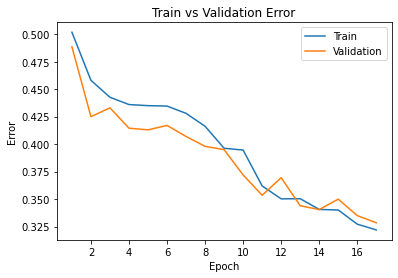

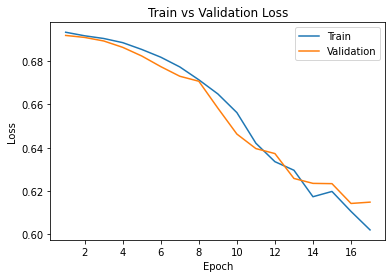

In [ ]:
large_net = LargeNet()
train_net(large_net, 512, 0.02, 17)
training_curve_large_improved = get_model_name("large", batch_size=512, learning_rate=0.02, epoch=16)
plot_training_curve(training_curve_large_improved)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=512, learning_rate=0.02, epoch=16)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

In [ ]:
# The reasoning behind the large_net choice is that it was found that the large network
# was less susceptible to noise and resulted in lower overall error values. The drawback
# of using the large network was the risk of overfitting at higher epoch values. To combat
# this effect, a batch size of 512 was chosen, as a higher batch size reduced the amount
# of overfitting that occurs at high epoch values. Furthermore, another added benefit
# of higher batch sizes was that it significantly sped up the training process.
# Furthermore, to help reduce the amount of overfitting, the epoch number was reduced to 17
# to minimize the chance of the large network overfitting. Finally, a learning rate of
# 0.02 was chosen to speed up the decline in both error and loss values.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=512)

loss_function_criterion = nn.BCEWithLogitsLoss()
error_val, loss_val = evaluate(net, test_loader, loss_function_criterion)
print("The test error value is", error_val, "and the test loss value is", loss_val)

Files already downloaded and verified
Files already downloaded and verified
The test error value is 0.3275 and the test loss value is 0.6124683022499084


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [ ]:
# I found that the test error value was around 0.3275 while the validation error value
# came out to be 0.3285. We can see that the test error value is slightly lower when
# compared to the validation error value. This is a bit unexpected as the model
# should theoretically be performing better on the validation error as than the test error,
# as the test error indicates how well the model performs when given a completely
# new set of data. Therefore, since the validation data has been tested multiple
# times using the model and the testing data has only been tested once, the error
# should be higher with the testing data.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [ ]:
# The test data set is used only at the very end as it gives the most realistic estimate
# of the model's performance when given a completely new set of data. If the testing
# data is used too often, we run the risk of the model basing its outputs solely off
# of the testing data and essentially memorizing the data. This would lead to overfitting
# and would provide us with a false sense of the model's actual performance when
# given new sets of data.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [ ]:
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.name = "pigeon"
        self.layer1 = nn.Linear(3072, 30)
        self.layer2 = nn.Linear(30, 1)
    def forward(self, img):
        flattened = img.view(-1, 3072)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1)
        return activation2

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.50475, Train loss: 0.6967718861997128 |Validation err: 0.5, Validation loss: 0.6945005059242249
Epoch 2: Train err: 0.46975, Train loss: 0.6884235888719559 |Validation err: 0.4465, Validation loss: 0.6869530230760574
Epoch 3: Train err: 0.43525, Train loss: 0.6818025670945644 |Validation err: 0.4195, Validation loss: 0.6816391795873642
Epoch 4: Train err: 0.418375, Train loss: 0.6764560975134373 |Validation err: 0.4115, Validation loss: 0.6771690100431442
Epoch 5: Train err: 0.412375, Train loss: 0.6721705123782158 |Validation err: 0.404, Validation loss: 0.673652395606041
Epoch 6: Train err: 0.406375, Train loss: 0.6692480929195881 |Validation err: 0.4105, Validation loss: 0.670731708407402
Epoch 7: Train err: 0.402125, Train loss: 0.6665838323533535 |Validation err: 0.4065, Validation loss: 0.6688121557235718
Epoch 8: Train err: 0.40025, Train loss: 0.6645312048494816 |Validation err: 0.

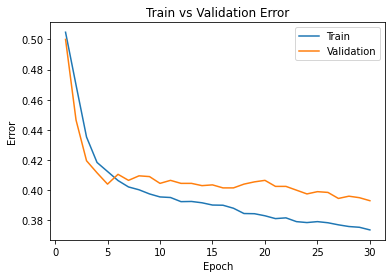

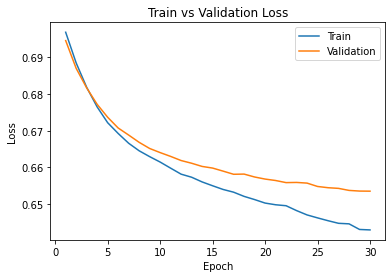

In [ ]:
pigeon = Pigeon()
train_net(pigeon, batch_size=512, learning_rate=0.001)
pigeon_path = get_model_name("pigeon", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(pigeon_path)

In [ ]:
# Testing Section
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=512)

loss_function_criterion = nn.BCEWithLogitsLoss()
error_val, loss_val = evaluate(pigeon, test_loader, loss_function_criterion)
print("The test error value is", error_val, "and the test loss value is", loss_val)

Files already downloaded and verified
Files already downloaded and verified
The test error value is 0.379 and the test loss value is 0.6470588892698288


In [ ]:
# The test error value for the 2 layer ANN was 0.379 which was relatively higher than the
# test error value for the CNN which was 0.3275. Therefore, this shows us that in
# this situation, the CNN is more optimized for the problem of classifying cats and dogs.